# Model Selection

*In which we choose the best model to predict the age of a crab.*


### Define Constants


In [24]:
CACHE_FILE = '../cache/crabs.feather'
NEXT_CACHE_FILE = '../cache/normlcrabs.feather'
NEXT_NOTEBOOK = '../2-features/features.ipynb'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]


### Importing Libraries


In [25]:
from notebooks.time_for_crab.mlutils import data_downcasting, display_df

import numpy as np
import pandas as pd

#from sklearn.svm import SVC
#from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


### Load Data from Cache

In the [previous section](../0-eda/overfit.ipynb), we saved the cleaned data to a cache file. Let's load it back.


In [26]:
crabs = pd.read_feather(CACHE_FILE)
display_df(crabs, show_distinct=True)


DataFrame shape: (3893, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3893 no

### Split the Data

Let's split the data into training and testing sets.

It is important to split the data before any data augmentation or normalization to avoid data leakage.  
Data leakage lets the model learn from the testing data, which can lead to overfitting.

In more general terms, *data leakage* is the phenomenon when the form of a label "leaks" into the training feature set.
An example this of occurred in 2021 for diagnosing Covid patients. Patients lying down on a bed were more likely to be "diagnosed" with Covid.
This is because patients confirmed to have Covid were more inclined to bed rest (Huyen, 2022). 


In [27]:
# split features from target
X = crabs.drop([PREDICTION_TARGET], axis=1)
y = crabs[PREDICTION_TARGET]
# 80% training, 20% testing
train_size = int(0.8 * len(crabs))
# shuffle the data
random_indices = np.random.default_rng(42).permutation(crabs.index)
# split into train/test sets
X_train = X.iloc[random_indices[0:train_size]]
X_test = X.drop(X_train.index)
y_train = y.iloc[random_indices[0:train_size]]
y_test = y.drop(y_train.index)
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')


X_train: (3114, 10)
X_test: (779, 10)


### Data Normalization

Crabs come in all shapes and sizes. Let's normalize the data to help our model make better sense of it.

![Tiny crab](https://www.popsci.com/uploads/2022/02/09/fiddler-crab.jpg?auto=webp&optimize=high&width=1440)

The book *Designing Machine Learning Systems* (Huyen, 2022) suggests normalizing to a range of [-1, 1] helps in practice.

Data normalization can help avoid data leakage based on the "form" of the data.

In [29]:
def data_normalization(df:pd.DataFrame, a:float=-1., b:float=1., df_min:pd.Series=None,  df_max:pd.Series=None) -> pd.DataFrame:
    """Normalize the DataFrame from a to b.
    
    :param df: The data.
    :param a: The minimum value.
    :param b: The maximum value.
    :param df_min: The minimum value of the data.
    :param df_max: The maximum value of the data.
    :return: The normalized data.
    """
    # scale the data to a range of [a, b]
    df_min = df.min() if df_min is None else df_min
    df_max = df.max() if df_max is None else df_max
    df = a + ((df - df_min) * (b - a)) / (df_max - df_min)
    return df


#### Show Distributions Before Normalization

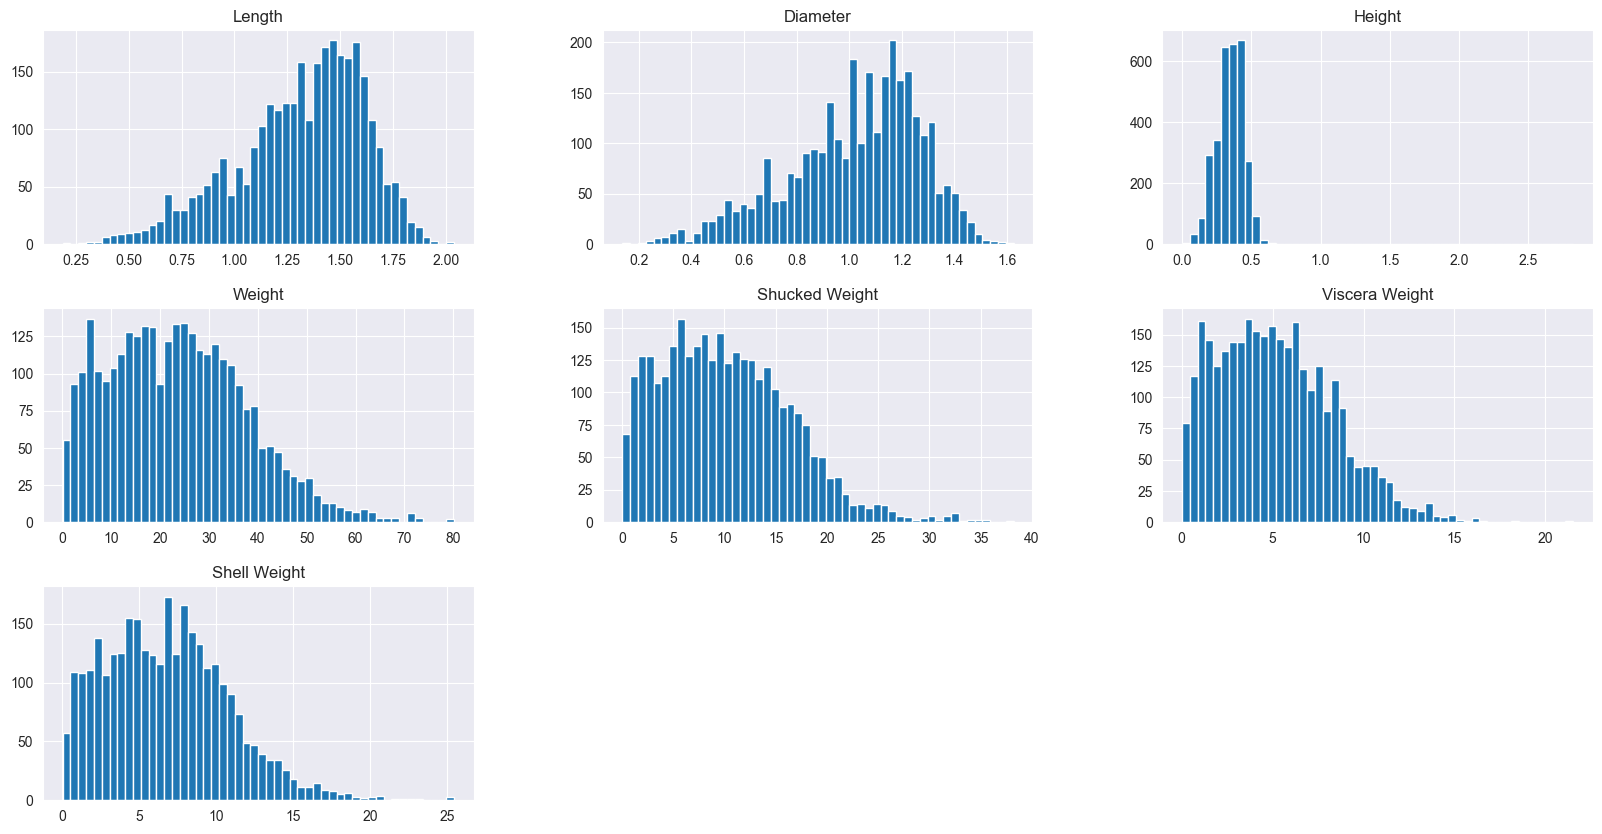

In [30]:
# Plotting the distribution of the features
X_train.hist(figsize=(20, 10), bins=50)
plt.title('Before Normalization')
plt.show()


In [31]:
# we're going to do something risky here and modify both the training and testing data
# we are going to save the test data to a cache file to be picked up later
# ensure we're only normalizing using parameters from the training data
for col in X_train.select_dtypes(include=[np.number]).columns:
    X_train[col] = data_normalization(X_train[col], df_min=X_train[col].min(), df_max=X_train[col].max())
    X_test[col] = data_normalization(X_test[col], df_min=X_train[col].min(), df_max=X_train[col].max())
X_train.describe().transpose()[['mean','std']]


,mean,std
Length,0.213989,0.329102
Diameter,0.185913,0.337891
Height,-0.752930,0.076477
Weight,-0.412354,0.351318
Shucked Weight,-0.467285,0.330566
Viscera Weight,-0.523438,0.292236
Shell Weight,-0.467773,0.314941


#### Show Distributions After Normalization

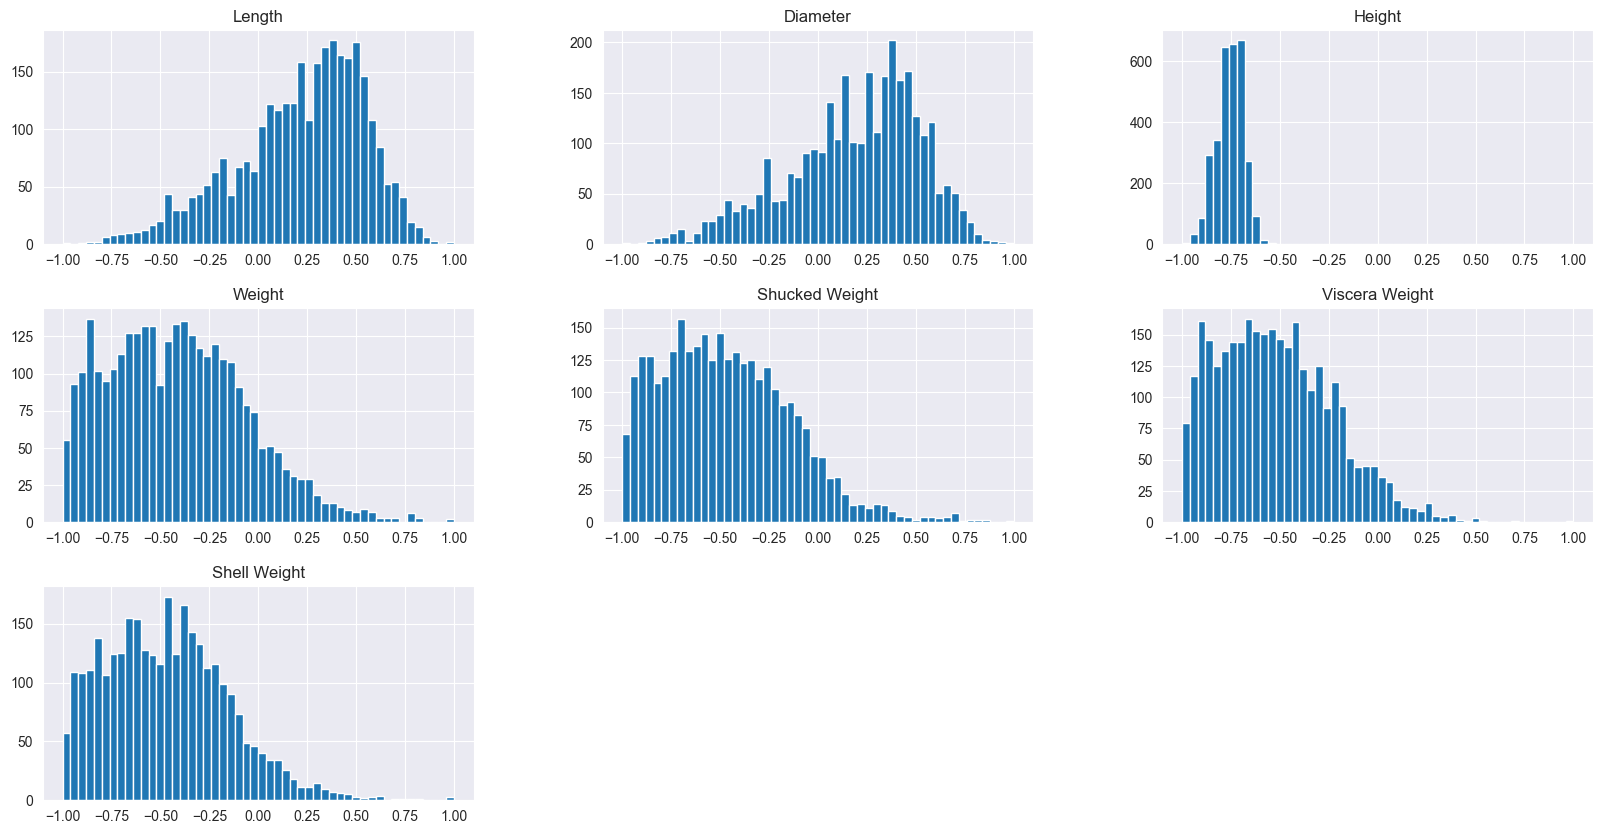

In [32]:
# Plotting the distribution of the features
X_train.hist(figsize=(20, 10), bins=50)
plt.title('After Normalization')
plt.show()


### Save the Data

So we can pick this back up on the [next step](../2-features/features.ipynb).


In [33]:
# save the training and test data separately
pd.concat([X_train, y_train], axis=1, join='outer').to_feather(NEXT_CACHE_FILE)
pd.concat([X_test, y_test], axis=1, join='outer').to_feather(NEXT_CACHE_FILE.replace('.feather', '_test.feather'))


### Onwards to Feature Engineering

See the [next section](../2-features/features.ipynb) for feature engineering.
